# Проект: Обучение с учителем для предсказания снижения покупательской активности

### 1. **Введение**
В условиях насыщенного рынка и высокой конкуренции интернет-магазин «В один клик» сталкивается с проблемой снижения активности постоянных клиентов. Традиционные методы привлечения новой аудитории становятся менее эффективными, что делает приоритетной задачу **удержания и повторной активации действующих клиентов**. Одним из путей решения данной задачи является внедрение **персонализированных предложений**, ориентированных на поведение и ценность конкретного покупателя.

---

### 2. **Цель проекта**
Разработка модели машинного обучения с учителем, способной предсказывать **вероятность снижения покупательской активности клиента** в течение следующих трёх месяцев. Полученные предсказания будут использоваться для **сегментации клиентов** и последующей генерации **таргетированных предложений**.

---

### 3. **Методология**
- **Тип задачи:** Бинарная классификация (целевая переменная — факт снижения активности).
- **Источник данных:** Поведенческие метрики клиентов (история покупок, частота и сумма заказов), а также данные о прибыльности клиента за последние три месяца, предоставленные финансовым департаментом.
- **Модель:** Рассматриваются базовые модели классификации: логистическая регрессия, метод K-ближайших соседей, дерево решений, метод опорных векторов.
- **Оценка качества:** Метрики качества модели включают AUC-ROC, F1-меру.

---

### 4. **Этапы проекта**
1. **Исследовательский анализ данных (EDA):** анализ поведения клиентов, выявление паттернов в истории покупок и прибыльности.
2. **Предобработка данных:** обработка пропусков, создание новых признаков.
3. **Построение и обучение модели:** выбор алгоритма, настройка гиперпараметров, обучение и валидация модели с использованием пайплайна.
4. **Сегментация клиентов:** на основе вероятности оттока и уровня прибыльности выделены 4 сегмента (например, "высокий риск — высокая ценность").
5. **Разработка стратегий:** для каждого сегмента предлагаются персонализированные акции, скидки, коммуникации (e-mail, push-уведомления и пр.).

---

### 5. **Практическая значимость**
Предложенное решение позволит бизнесу:
- Своевременно выявлять клиентов с высоким риском снижения активности;
- Эффективнее распределять маркетинговый бюджет;
- Увеличить пожизненную ценность клиента (CLV) за счёт таргетированных действий;
- Повысить общий уровень удержания клиентов.


## Шаг 1. Загрузка данных
- 1.1 Загрузите данные. 
- Обратите внимание: в некоторых файлах разделитель значений — точка с запятой, а разделитель десятичных значений — запятая.  
- 1.2 Проверьте, что данные в таблицах соответствуют описанию. Исследованием и объединением данных вы займётесь позже.

In [1]:
# скачиваю новые версии библиотек
!pip install --upgrade numba pandas numpy scikit-learn matplotlib seaborn phik optuna optuna-integration[sklearn] shap -q 

In [2]:
# Импорт необходимых библиотек
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import LabelEncoder

# Импортирую библиотеку pandas для работы с таблицами
import pandas as pd

# Импортирую библиотеки matplotlib и seaborn для работы с графиками
import matplotlib.pyplot as plt
import seaborn as sns

# Импортирую библиотеки numpy и scipy для работы с вычислениями и статистикой
import numpy as np
from scipy import stats as st
from scipy.stats import binom
from math import factorial

# Импорт необходимых библиотек phik
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

# Импорт моделей и алгоритмов из sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

# Импорт методов оценки модели из sklearn
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             roc_auc_score, accuracy_score, precision_score,
                             recall_score, confusion_matrix)

# Импорт методов разделения данных и кросс-валидации из sklearn
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     train_test_split, cross_val_score)

# Импорт методов предобработки данных из sklearn
from sklearn.preprocessing import (OneHotEncoder, OrdinalEncoder,
                                   StandardScaler, MinMaxScaler)
from sklearn.compose import ColumnTransformer

# Импорт методов обработки пропусков из sklearn
from sklearn.impute import SimpleImputer

# Импорт Pipeline для создания последовательностей обработки данных из sklearn
from sklearn.pipeline import Pipeline

# Импорт библиотек для оптимизации гиперпараметров
import optuna
from optuna.integration import OptunaSearchCV
from optuna import distributions

# Импорт библиотеки SHAP для объяснения моделей
import shap

In [3]:
# Константы

RANDOM_STATE = 42
TEST_SIZE = 0.25

In [4]:
# Сохраняю файлы в отдельные датафреймы

try:
    main = pd.read_csv('market_file.csv', sep=',', decimal=',')
    money = pd.read_csv('market_money.csv', sep=',', decimal=',')
    time = pd.read_csv('market_time.csv', sep=',', decimal=',')
    income = pd.read_csv('money.csv', sep=';', decimal=',')
except:
    main = pd.read_csv('/datasets/market_file.csv', sep=',', decimal=',')
    money = pd.read_csv('/datasets/market_money.csv', sep=',', decimal=',')
    time = pd.read_csv('/datasets/market_time.csv', sep=',', decimal=',')
    income = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')

In [5]:
# функция для ознакомления с датафпреймами

def intro(df, name="DataFrame"):
    print()   
    print(f"Датафрейм: {name}")
    print()   
    display(df.head())  # Вывод первых 5 строк DataFrame
    print()           # Печатаем пустую строку для разделения
    df.info()        # Вывод информации о DataFrame


In [6]:
# проверяю датафреймы

intro(main, name="main, Данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении")
intro(money, name="money, Данные о выручке, которую получает магазин с покупателя")
intro(time, name="time, Данные о времени (в минутах), которое покупатель провёл на сайте")
intro(income, name="income, Данными о среднемесячной прибыли покупателя за 3 мес.")


Датафрейм: main, Данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении



,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype 
---  ------                               --------------  ----- 
 0   id                                   1300 non-null   int64 
 1   Покупательская активность            1300 non-null   object
 2   Тип сервиса                          1300 non-null   object
 3   Разрешить сообщать                   1300 non-null   object
 4   Маркет_актив_6_мес                   1300 non-null   object
 5   Маркет_актив_тек_мес                 1300 non-null   int64 
 6   Длительность                         1300 non-null   int64 
 7   Акционные_покупки                    1300 non-null   object
 8   Популярная_категория                 1300 non-null   object
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64 
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64 
 11  Ошибка_сервиса                       1300 

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       3900 non-null   int64 
 1   Период   3900 non-null   object
 2   Выручка  3900 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.5+ KB

Датафрейм: time, Данные о времени (в минутах), которое покупатель провёл на сайте



,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB

Датафрейм: income, Данными о среднемесячной прибыли покупателя за 3 мес.



,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


#### Содержания датафреймов:

Файл `market_file.csv` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
Описание данных:

- `id` — номер покупателя в корпоративной базе данных.
- `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
- `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
- `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
- `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Файл `money.csv` - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.
Описание данных:
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- `Выручка`— сумма выручки за период.

Файл `time.csv` - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.
Описание данных:
- `id` — номер покупателя в корпоративной базе данных.
- `Период` — название периода, во время которого зафиксировано общее время.
минут — значение времени, проведённого на сайте, в минутах.

Файл `income.csv` - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.
Описание данных:
- `id` — номер покупателя в корпоративной базе данных.
- `Прибыль` — значение прибыли.


## Выводы: 
- неправильные типы данных `Маркет_актив_6_мес`, `Акционные_покупки`, `Выручка`
- пропусков нет
- данные соответствуют описанию
- названия столбцов оставлю как есть.

## Шаг 2. Предобработка данных
Проведите необходимую предобработку данных. Названия столбцов можно оставить кириллическими.

In [7]:
# смена неправильных типов данных
main['Маркет_актив_6_мес'] = main['Маркет_актив_6_мес'].astype(float)
main['Акционные_покупки'] = main['Акционные_покупки'].astype(float)

main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [8]:
money['Выручка'] = money['Выручка'].astype(float)
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [9]:
# функция проверки на дубликаты и пустые значения

def dataset_dubnan(dataset):
    print('Количество явных дубликатов в датасете:', dataset.duplicated().sum())
    print('Количество пропусков в датасете:')
    print(dataset.isnull().sum())

# список датасетов
datasets = [main, money, time, income]

# цикл для датасетов
for i, dataset in enumerate(datasets):
    print(f'\nДатасет {i + 1}:')
    dataset_dubnan(dataset)



Датасет 1:
Количество явных дубликатов в датасете: 0
Количество пропусков в датасете:
id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

Датасет 2:
Количество явных дубликатов в датасете: 0
Количество пропусков в датасете:
id         0
Период     0
Выручка    0
dtype: int64

Датасет 3:
Количество явных дубликатов в датасете: 0
Количество пропусков в датасете:
id        0
Период    0
минут     0
dtype: int64

Датасет 4:
Количество явных дубликатов в датасете: 0
Количество пропусков в датасете:
id   

In [10]:
# Показывает информацию о категориальных значениях по каждому параметру в DataFrame.

def display_categorical_info(df):
    for column in df.columns:
        # Проверяем, является ли столбец категориальным
        if isinstance(df[column].dtype, pd.CategoricalDtype) or pd.api.types.is_object_dtype(df[column]):
            unique_values = df[column].unique()
            unique_count = len(unique_values)
            
            print(f"Столбец '{column}':")
            print(f"  Количество уникальных значений: {unique_count}")
            print("  Уникальные значения:")
            for value in unique_values:
                print(f"  - {value}")
            print()  # Пустая строка для разделения между столбцами
        else:
            print(f"Столбец '{column}' не является категориальным.\n")

In [11]:
display_categorical_info(main)

Столбец 'id' не является категориальным.

Столбец 'Покупательская активность':
  Количество уникальных значений: 2
  Уникальные значения:
  - Снизилась
  - Прежний уровень

Столбец 'Тип сервиса':
  Количество уникальных значений: 3
  Уникальные значения:
  - премиум
  - стандартт
  - стандарт

Столбец 'Разрешить сообщать':
  Количество уникальных значений: 2
  Уникальные значения:
  - да
  - нет

Столбец 'Маркет_актив_6_мес' не является категориальным.

Столбец 'Маркет_актив_тек_мес' не является категориальным.

Столбец 'Длительность' не является категориальным.

Столбец 'Акционные_покупки' не является категориальным.

Столбец 'Популярная_категория':
  Количество уникальных значений: 6
  Уникальные значения:
  - Товары для детей
  - Домашний текстиль
  - Косметика и аксесуары
  - Техника для красоты и здоровья
  - Кухонная посуда
  - Мелкая бытовая техника и электроника

Столбец 'Средний_просмотр_категорий_за_визит' не является категориальным.

Столбец 'Неоплаченные_продукты_штук_кварт

In [12]:
# замена опечаток
main.loc[main['Тип сервиса'] == 'стандартт', 'Тип сервиса'] = 'стандарт'
main['Тип сервиса'].unique() # проверка

array(['премиум', 'стандарт'], dtype=object)

In [13]:
display_categorical_info(money)

Столбец 'id' не является категориальным.

Столбец 'Период':
  Количество уникальных значений: 3
  Уникальные значения:
  - препредыдущий_месяц
  - текущий_месяц
  - предыдущий_месяц

Столбец 'Выручка' не является категориальным.



In [14]:
display_categorical_info(time)

Столбец 'id' не является категориальным.

Столбец 'Период':
  Количество уникальных значений: 2
  Уникальные значения:
  - текущий_месяц
  - предыдцщий_месяц

Столбец 'минут' не является категориальным.



In [15]:
# замена опечаток
time['Период'] = time['Период'].replace('предыдцщий_месяц', 'предыдущий_месяц')
time['Период'].unique()

array(['текущий_месяц', 'предыдущий_месяц'], dtype=object)

In [16]:
money.loc[money['Период'] == 'препредыдущий_месяц', 'Период'] = 'предыдущий_месяц'
money

,id,Период,Выручка
0,215348,предыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,предыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
...,...,...,...
3895,216646,предыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,предыдущий_месяц,5183.0


## Вывод:
- испавлены опечатки  в`main['Тип сервиса']` (стандарт) и  в `time['Период']` (предыдущий_месяц), `time['Период']`(препредыдущий_месяц)
- дубликаты не выявлены
- смена типов данных в `main['Маркет_актив_6_мес']`, `money['Выручка']`,
`main['Акционные_покупки']` на float.

## Шаг 3. Исследовательский анализ данных
- Проведите исследовательский анализ данных из каждой таблицы. 
- Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. 
- Оформите выводы по результатам шага.

## Датафрейм Main

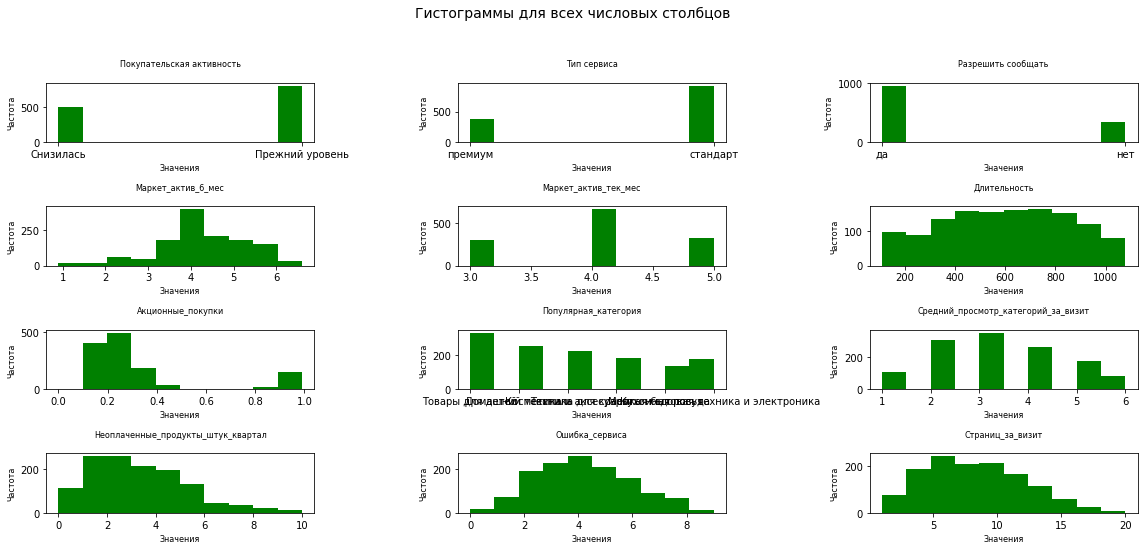

In [17]:
# Создаем фигуру и подграфики (2 ряда по 4 графика)
fig, ax = plt.subplots(4, 3, figsize=(16, 8))

# Плоский массив осей для удобства итерации
axes = ax.flatten()

# Построение гистограмм для всех числовых столбцов (кроме первого)
for i in range(min(len(main.columns) - 1, len(axes))):
    axes[i].hist(main.iloc[:, i + 1], bins=10, color='green')
    axes[i].set_title(f'{main.columns[i + 1]}\n', fontsize=8)  # Заголовок с переносом строки
    axes[i].set_xlabel('Значения', fontsize=8)   # Подпись оси X
    axes[i].set_ylabel('Частота', fontsize=8)     # Подпись оси Y

# Отключаем лишние оси, если их меньше чем подграфиков
for j in range(len(main.columns) - 1, len(axes)):
    axes[j].axis('off')

# Общий заголовок для всего графика
plt.suptitle('Гистограммы для всех числовых столбцов', fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Подгонка для общего заголовка

# Показать график
plt.show()


In [18]:
# изучаю датафрейм
main.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [19]:
# функция для создания графиков

def plots(column):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    sns.set() 
    sns.set_style("whitegrid")
    custom_palette = sns.color_palette(['#f7bdd1', '#66B3FF'])
    sns.histplot(column, ax=axes[0], color='orange', bins=30)  # для графика
    axes[0].set_title('Диаграмма распределения') 
    axes[0].axvline(x=np.nanmean (column), color='blue', linestyle='-', linewidth= 2 , label='Среднее') 
    axes[0].axvline(x=np.nanmedian (column), color='red', linestyle='--', linewidth= 2 , label='Медиана') 
    axes[0].set_ylabel('Частотность')
    sns.boxplot(x=column, ax=axes[1], color='#66B3FF', showfliers=False)  # для графика
    sns.stripplot(x=column, color="orange", jitter=0.2, size=2.5, ax=axes[1])
    axes[1].set_title('Диаграмма размаха')  # Добавьте заголовок для ящика с усами# Добавьте заголовок для гистограммы
    plt.tight_layout() #подбирает оптимальное расположение подграфиков 
    plt.show();



In [20]:
# функция для создания графиков

def plots_discr(column):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    sns.set() 
    sns.set_style("whitegrid")
    custom_palette = sns.color_palette(['#f7bdd1', '#66B3FF'])
    sns.countplot(column, ax=axes[0], color='red')
    axes[0].set_title('Диаграмма распределения') 
    axes[0].axvline(x=np.nanmean (column), color='blue', linestyle='-', linewidth= 2 , label='Среднее') 
    axes[0].axvline(x=np.nanmedian (column), color='red', linestyle='--', linewidth= 2 , label='Медиана') 
    axes[0].set_ylabel('Частотность')
    sns.boxplot(x=column, ax=axes[1], color='#66B3FF', showfliers=False)  # для графика
    sns.stripplot(x=column, color="orange", jitter=0.2, size=2.5, ax=axes[1])
    axes[1].set_title('Диаграмма размаха')  # Добавьте заголовок для ящика с усами# Добавьте заголовок для гистограммы
    plt.tight_layout() #подбирает оптимальное расположение подграфиков 
    plt.show();



In [21]:
def plots_disc(column):
 
    fig, ax = plt.subplots(figsize=(12, 4))  # Создаем одну ось
    sns.set() 
    sns.set_style("whitegrid")
    sns.countplot(x=column, ax=ax, color='red', label='Частота')
    ax.set_title('Диаграмма распределения') 
    ax.set_ylabel('Частотность')
    plt.tight_layout()
    ax.legend()
    plt.show()


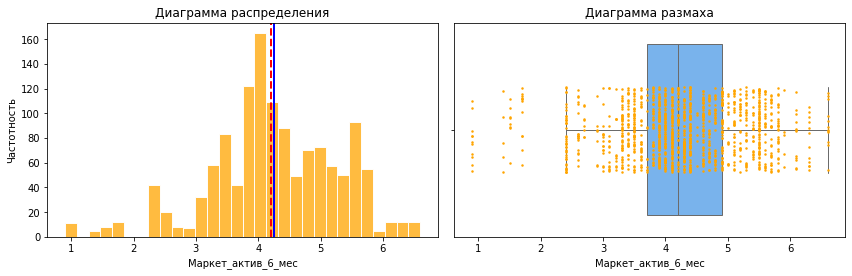

In [22]:
plots(main['Маркет_актив_6_мес']);

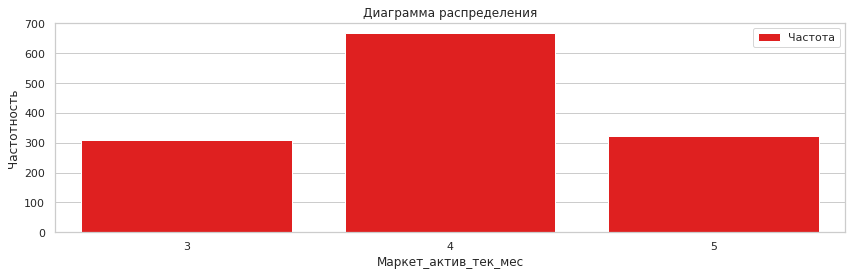

In [23]:
plots_disc(main['Маркет_актив_тек_мес']);

- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев равно примерно 4 коммуникациям. В целом проходит от 1 до 6.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце так же в среднем около 4 штук. В целом проходит от 3 до 5.

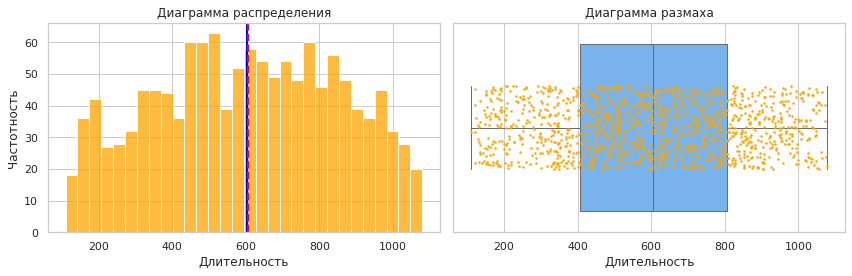

In [24]:
plots(main['Длительность']);

- Длительность — 600 дней - среднее кол-во дней прошло с момента регистрации покупателя на сайте. 
Большинство клиентов достаточно давно зарегистрировались. Размах от 110 дней до 1079.

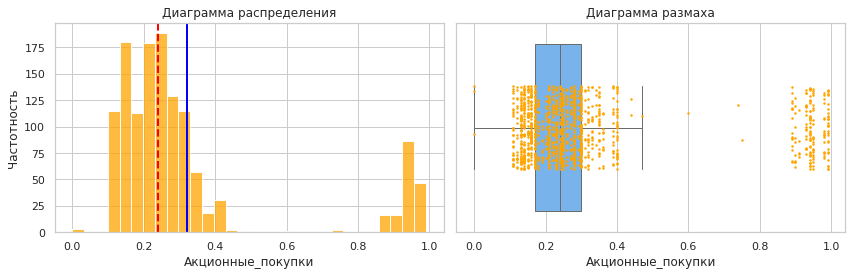

In [25]:
plots(main['Акционные_покупки']);

In [26]:
# Функция для распределения
def categorize(value):
    if value <= 0.6:
        return 'Минимум акций'
    else:
        return 'Только акции'

# Применение функции к столбцу
main['Акционники'] = main['Акционные_покупки'].apply(categorize)

# Вывод результата
# main.head()

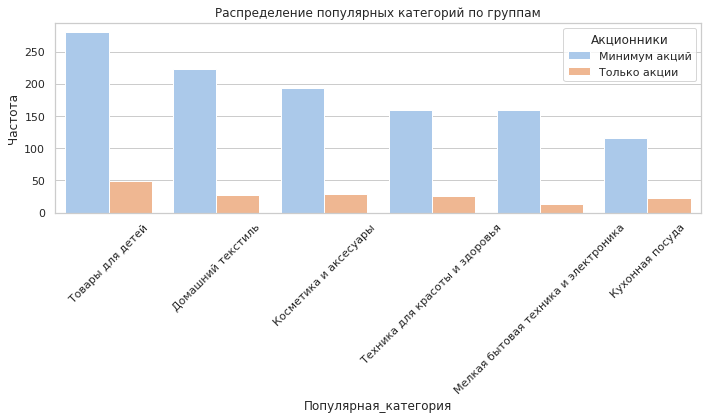

In [27]:
# Фильтрация данных для Только акци
filtered_data = main.query('Акционники == "Только акции"')['Популярная_категория']

# Подсчет количества вхождений каждой категории
category_counts = main['Популярная_категория'].value_counts()

# Сортировка категорий от большего к меньшему
sorted_categories = category_counts.index

# Построение гистограммы с отсортированными категориями
plt.figure(figsize=(10, 6))
sns.countplot(x='Популярная_категория', hue='Акционники', data=main, palette='pastel',
              order=sorted_categories)  # Используем отсортированные категории

# Настройка заголовков и меток
plt.title('Распределение популярных категорий по группам')
plt.ylabel('Частота')
plt.xticks(rotation=45)  # Поворот меток по оси X для лучшей читаемости
plt.tight_layout()  # Подгонка макета

# Показать график
plt.show()

- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев - низкая.
Средняя и медиана разные, видна ассиметрия - два пика. Скорее всего есть две категории - кто кладет мин акционных товаров и кто покупает только их.
Похоже на первую сегментацию.
Сегмент "Только по акции" - покупают больше всего товары для детей.

In [28]:
main.describe()

,id,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


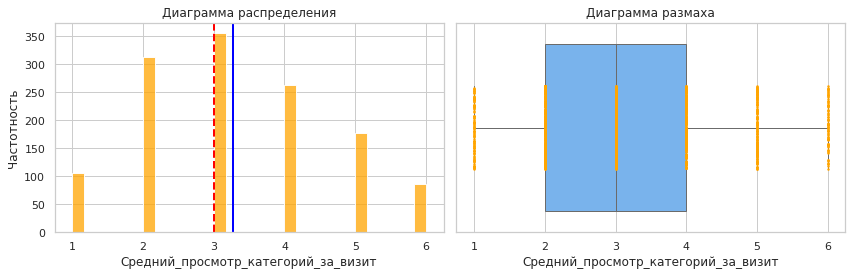

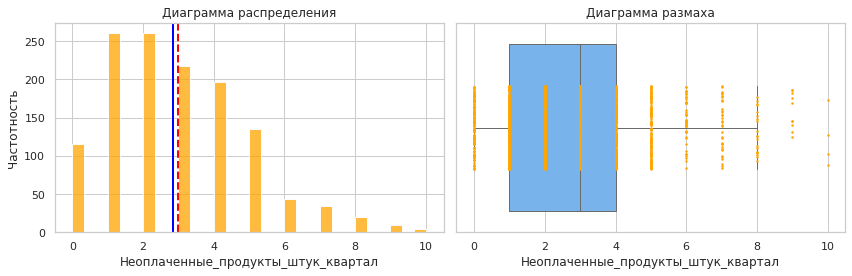

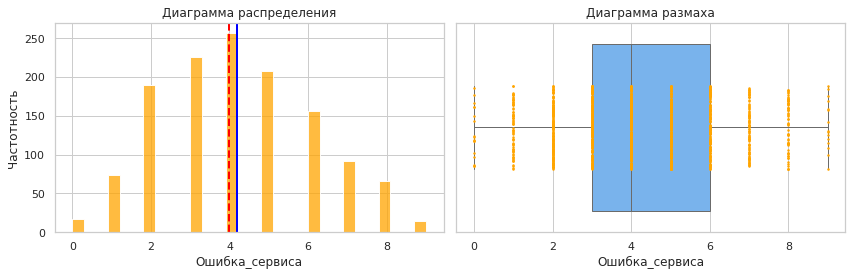

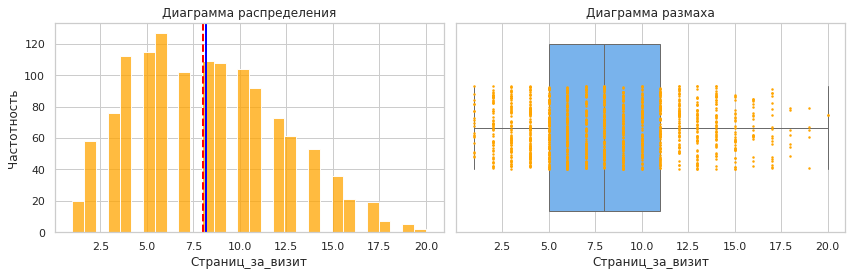

In [29]:
plots(main['Средний_просмотр_категорий_за_визит']);
plots(main['Неоплаченные_продукты_штук_квартал']);
plots(main['Ошибка_сервиса']);
plots(main['Страниц_за_визит']);

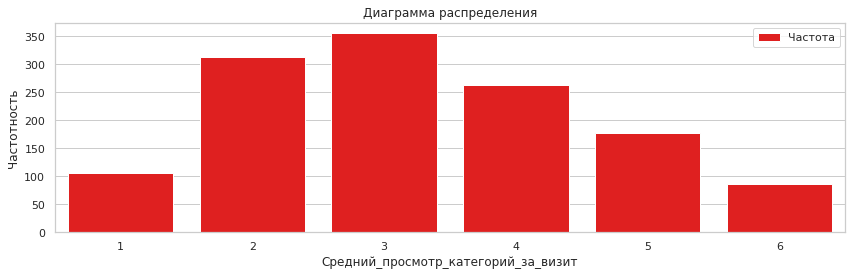

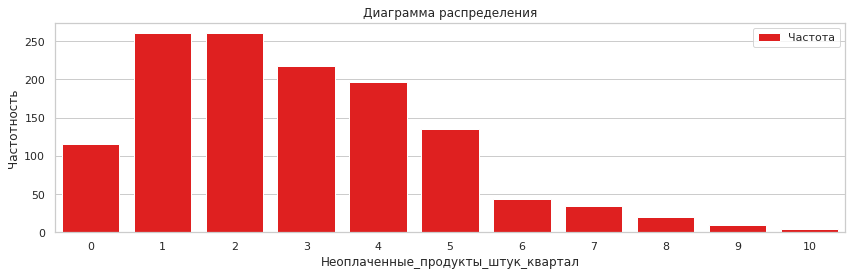

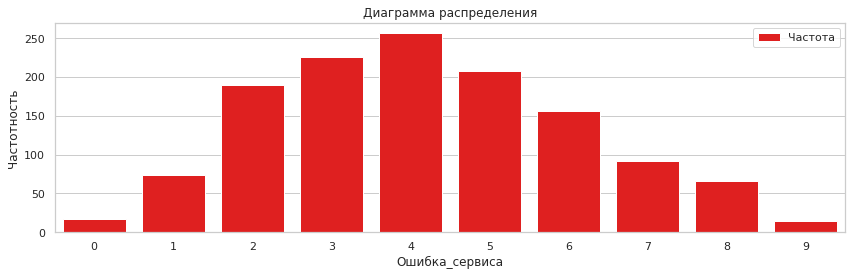

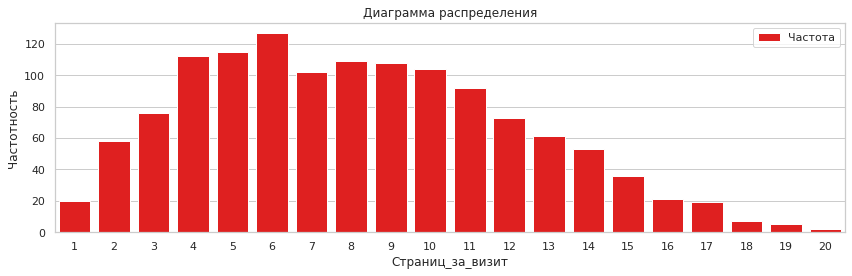

In [30]:
plots_disc(main['Средний_просмотр_категорий_за_визит']);
plots_disc(main['Неоплаченные_продукты_штук_квартал']);
plots_disc(main['Ошибка_сервиса']);
plots_disc(main['Страниц_за_визит']);

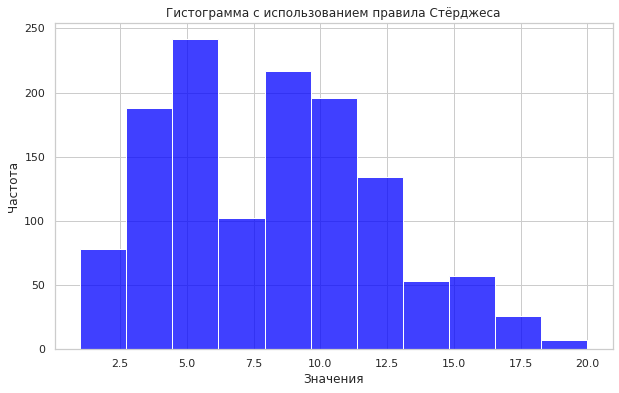

In [31]:
# Определение количества бинов по правилу Стёрджеса
n = len(main['Страниц_за_визит'])
k = int(np.floor(np.log2(n) + 1))

# Построение гистограммы
plt.figure(figsize=(10, 6))
sns.histplot(main['Страниц_за_визит'], bins=k, kde=False, color='blue')
plt.title('Гистограмма с использованием правила Стёрджеса')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

- `Средний_просмотр_категорий_за_визит` — 3-4 категории в среднем покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — около 3 неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — 4 - число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — около 8 - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

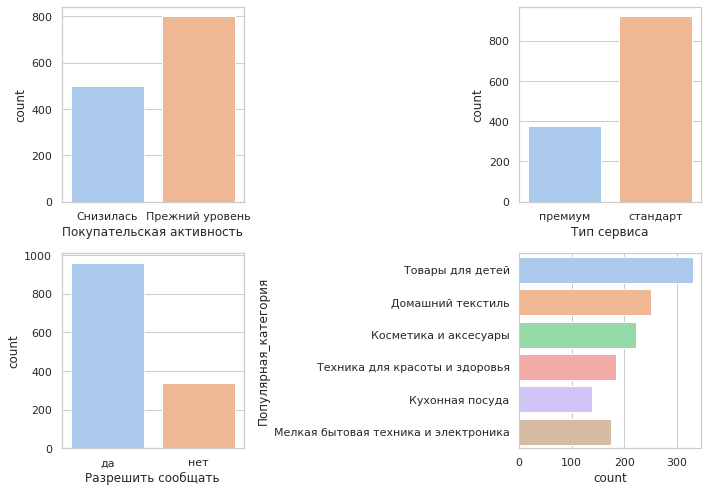

In [32]:
# Создаем фигуру с подграфиками
fig, axes = plt.subplots(2, 2, figsize=(10, 7))

# Гистограмма для первой категории
sns.countplot(x='Покупательская активность', data=main, ax=axes[0, 0], palette='pastel')

# Гистограмма для второй категории
sns.countplot(x='Тип сервиса', data=main, ax=axes[0, 1], palette='pastel')

# Гистограмма для третьей категории
sns.countplot(x='Разрешить сообщать', data=main, ax=axes[1, 0], palette='pastel')

# Гистограмма для четвертой категории
sns.countplot(y='Популярная_категория', data=main, ax=axes[1, 1], palette='pastel')


# Настройка общего оформления графиков
plt.tight_layout()
plt.show()

- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев равно примерно 4 коммуникациям. В целом проходит от 1 до 6.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце так же в среднем около 4 штук. В целом проходит от 3 до 5.
- Длительность — 600 дней - среднее кол-во дней прошло с момента регистрации покупателя на сайте. 
Большинство клиентов достаточно давно зарегистрировались. Размах от 110 дней до 1079.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев - низкая.
Средняя и медиана разные, видна ассиметрия - два пика. Скорее всего есть две категории - кто кладет мин акционных товаров и кто покупает только их.
Похоже на первую сегментацию.
Сегмент "Только по акции" - покупают больше всего товары для детей.
- `Средний_просмотр_категорий_за_визит` — 3-4 категории в среднем покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — около 3 неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — 4 - число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — около 8 - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
- `Покупательская активность` — больше осталась на прежнем уровне.
- `Тип сервиса` — стандарт больше, чем премиум.
- `Разрешить сообщать` — большинство отвечают - да.
- `Популярная_категория` — топ3: товары для детей, дом текстиль, косметика и аксессуары.

## Датафреймы Money и Income

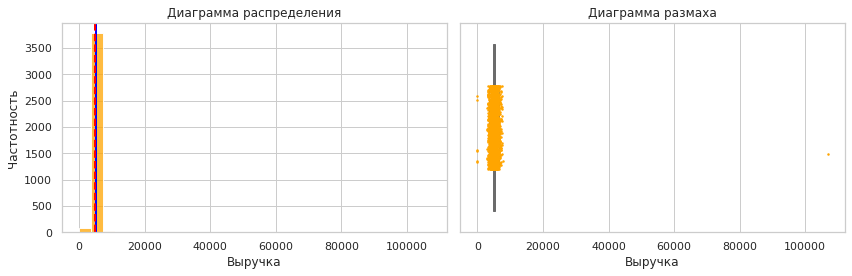

In [33]:
plots(money['Выручка']);

In [34]:
# находим выбросы 0 и 106862.2
money.sort_values(by='Выручка', ascending=False).head(3)

,id,Период,Выручка
98,215380,текущий_месяц,106862.2
435,215493,текущий_месяц,7799.4
262,215435,текущий_месяц,7605.3


In [35]:
money.describe()

,id,Выручка
count,3900.000000,3900.000000
mean,215997.500000,5025.696051
std,375.325686,1777.704104
min,215348.000000,0.000000
25%,215672.750000,4590.150000
50%,215997.500000,4957.500000
75%,216322.250000,5363.000000
max,216647.000000,106862.200000


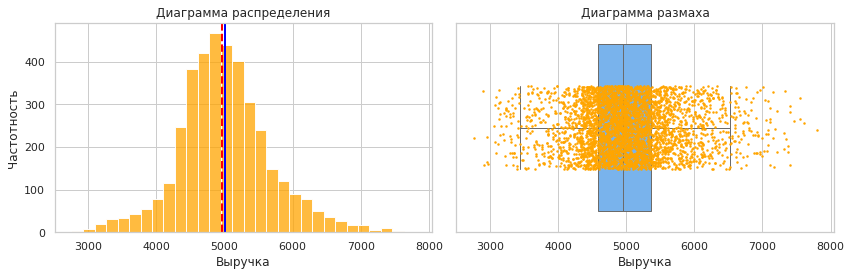

In [36]:
# убираем выброс 
money = money[(money['Выручка'] != 106862.2) & (money['Выручка'] != 0)]

plots(money['Выручка']);

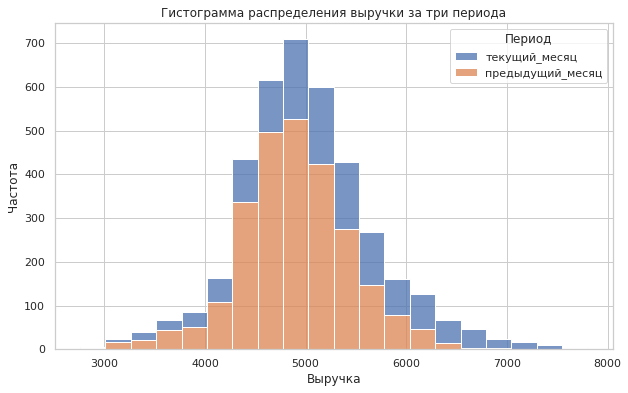

In [37]:
# рассмотрим отдельно три графика

plt.figure(figsize=(10, 6))
sns.histplot(data=money, x='Выручка', hue='Период', multiple='stack', bins=20)

plt.title('Гистограмма распределения выручки за три периода')
plt.xlabel('Выручка')
plt.ylabel('Частота')

plt.show()

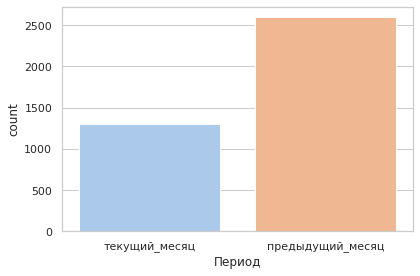

In [38]:
# Гистограмма для первой категории
sns.countplot(x='Период', data=money, palette='pastel')

# Настройка общего оформления графиков
plt.tight_layout()
plt.show()

In [39]:
income.describe()

,id,Прибыль
count,1300.000000,1300.000000
mean,215997.500000,3.996631
std,375.421985,1.013722
min,215348.000000,0.860000
25%,215672.750000,3.300000
50%,215997.500000,4.045000
75%,216322.250000,4.670000
max,216647.000000,7.430000


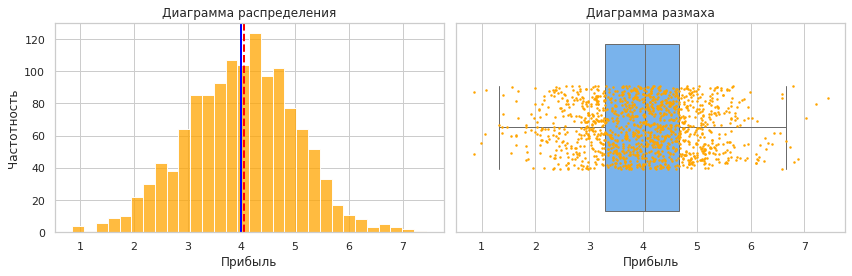

In [40]:
plots(income['Прибыль']);

- `Период` — выручки по предыдущему месяцу было больше.
- `Выручка` — за все периоды за одного клиента около в среднем 5000. Максимальная выручка - 7799 и это в текущем месяце. В предыдущем выручка просела.
- `Прибыль` — среднее значение среднемесячной прибыли покупателя за последние 3 месяца - около 4.

## Датафрейм time

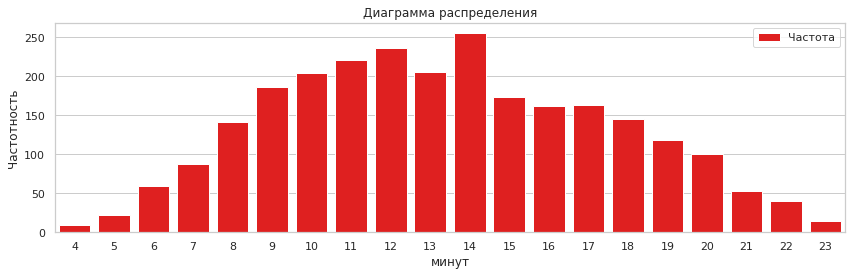

In [41]:
plots_disc(time['минут']);

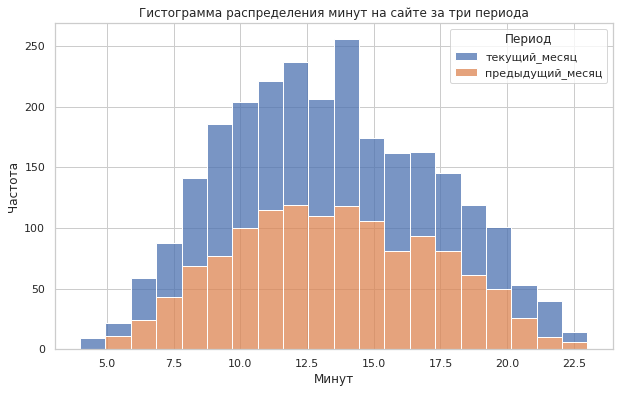

In [42]:
# рассмотрим отдельно три графика

plt.figure(figsize=(10, 6))
sns.histplot(data=time, x='минут', hue='Период', multiple='stack', bins=20)

plt.title('Гистограмма распределения минут на сайте за три периода')
plt.xlabel('Минут')
plt.ylabel('Частота')

plt.show()


- Около 12.5 минут в среднем проводит клиент.
- В текущем месяце клиент проводит гораздо больше времени на сайте.

## Шаг 4. Объединение таблиц
4.1 Объедините таблицы market_file.csv, market_money.csv, market_time.csv. Данные о прибыли из файла money.csv при моделировании вам не понадобятся. 
4.2 Учитывайте, что данные о выручке и времени на сайте находятся в одном столбце для всех периодов. В итоговой таблице сделайте отдельный столбец для каждого периода.

In [43]:
# делаю сводную таблицу для каждого периода
money_pivot = pd.pivot_table(money, index='id', columns='Период', values='Выручка')
money_pivot.columns = ['Выручка_пред_месяц', 'Выручка_тек_месяц']
money_pivot

,Выручка_пред_месяц,Выручка_тек_месяц
id,,
215348,NaN,3293.1
215349,4844.00,4971.6
215350,5141.75,5058.4
215351,5475.50,6610.4
215352,5200.75,5872.5
...,...,...
216643,4184.00,4741.7
216644,5014.00,5353.0
216645,5247.00,5139.2


In [44]:
# проверяю что за NaN - похоже на новых клиентов или те, которые не покупали в другом месяце
rows_with_nan = money_pivot[money_pivot.isna().any(axis=1)]
rows_with_nan

,Выручка_пред_месяц,Выручка_тек_месяц
id,,
215348,NaN,3293.1
215357,NaN,5986.3
215359,NaN,4735.0
215380,5564.0,NaN


In [45]:
# удаляю эти ненужные строки
money_pivot.dropna(axis=0, how='any', inplace=True)
money_pivot

,Выручка_пред_месяц,Выручка_тек_месяц
id,,
215349,4844.00,4971.6
215350,5141.75,5058.4
215351,5475.50,6610.4
215352,5200.75,5872.5
215353,4931.25,5388.5
...,...,...
216643,4184.00,4741.7
216644,5014.00,5353.0
216645,5247.00,5139.2


In [46]:
# делаю сводную таблицу для каждого периода
time_pivot = pd.pivot_table(time, index='id', columns='Период', values='минут')
time_pivot.columns = ['Минут_пред_месяц', 'Минут_тек_месяц']
time_pivot

,Минут_пред_месяц,Минут_тек_месяц
id,,
215348,13.0,14.0
215349,12.0,10.0
215350,8.0,13.0
215351,11.0,13.0
215352,8.0,11.0
...,...,...
216643,14.0,7.0
216644,12.0,11.0
216645,12.0,18.0


In [47]:
# соединяю наконец таблицы
full = main.merge(money_pivot, on='id', how='inner').merge(time_pivot, on='id', how='inner')
full

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Акционники,Выручка_пред_месяц,Выручка_тек_месяц,Минут_пред_месяц,Минут_тек_месяц
0,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,Только акции,4844.00,4971.6,12.0,10.0
1,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,Минимум акций,5141.75,5058.4,8.0,13.0
2,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,Только акции,5475.50,6610.4,11.0,13.0
3,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,Только акции,5200.75,5872.5,8.0,11.0
4,215353,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,Минимум акций,4931.25,5388.5,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,216643,Прежний уровень,стандарт,да,6.6,3,318,0.24,Техника для красоты и здоровья,5,3,3,11,Минимум акций,4184.00,4741.7,14.0,7.0
1292,216644,Прежний уровень,стандарт,нет,5.1,4,454,0.21,Домашний текстиль,6,2,3,9,Минимум акций,5014.00,5353.0,12.0,11.0
1293,216645,Прежний уровень,стандарт,да,4.1,3,586,0.20,Домашний текстиль,3,2,5,7,Минимум акций,5247.00,5139.2,12.0,18.0
1294,216646,Прежний уровень,стандарт,да,6.3,5,645,0.12,Техника для красоты и здоровья,3,3,5,7,Минимум акций,4824.00,5224.6,18.0,7.0


## Шаг 5. Корреляционный анализ
Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

Для анализа взаимосвязей между признаками различных типов можно использовать метод phik_matrix из библиотеки phik. Этот метод позволяет строить матрицы корреляции, учитывающие категориальные данные, что особенно полезно в вашем случае с двумя категориями пользователей: те, чья активность снизилась, и те, чья активность осталась на прежнем уровне.
Порог корреляционной связи - 0.75.

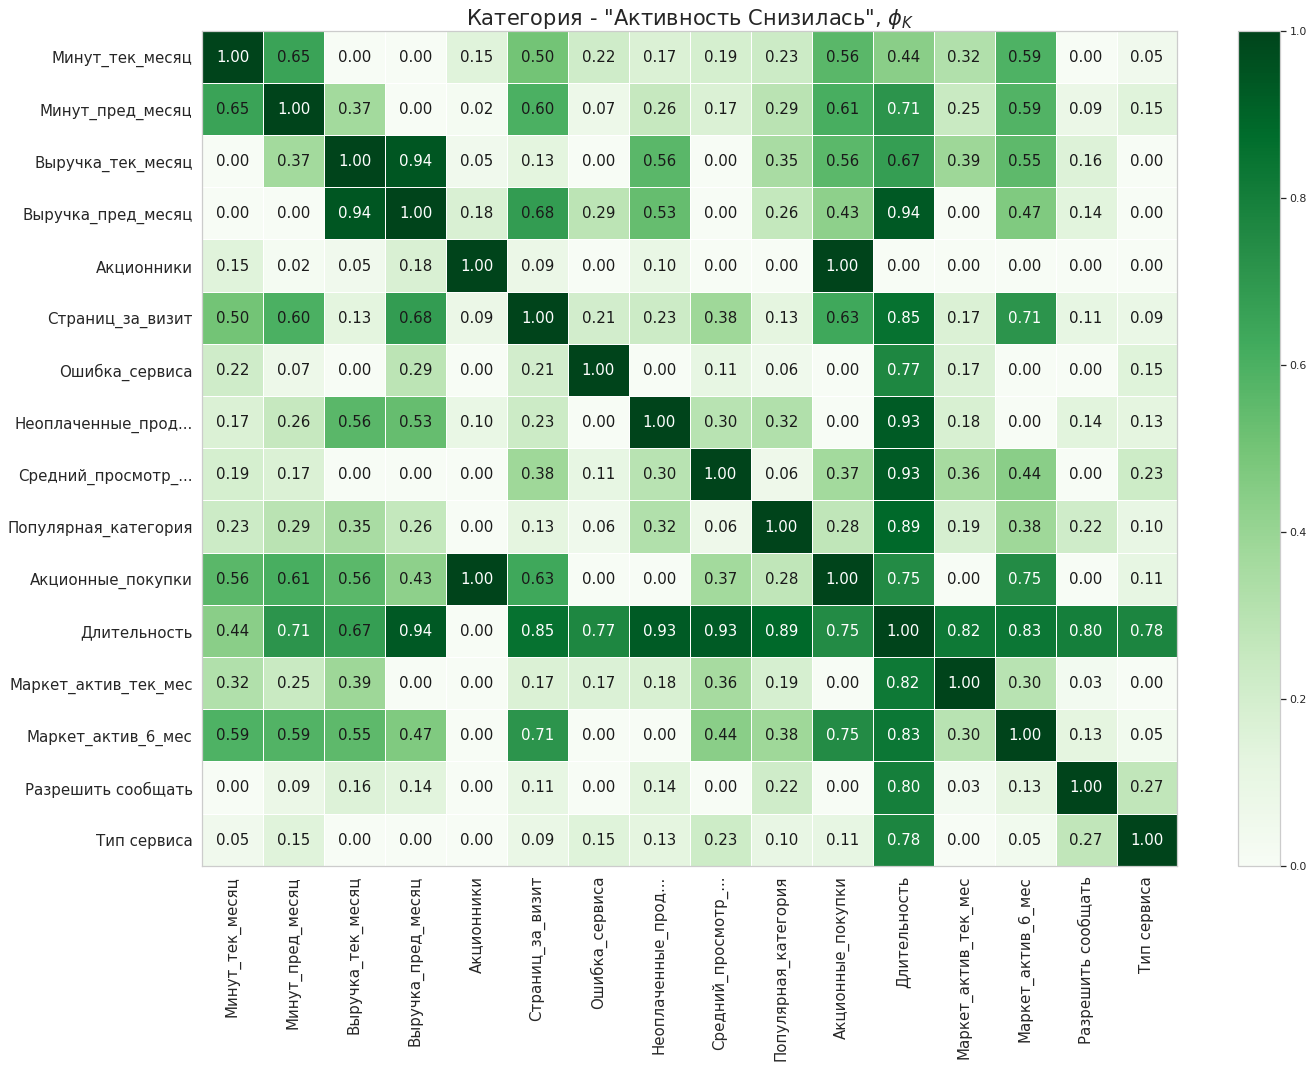

In [48]:
interval_cols = full.drop('id', axis=1).select_dtypes(include='float').columns.tolist()
#interval_cols = full.drop('id', axis=1).select_dtypes(include='number').select_dtypes(exclude='int').columns.tolist()

phik_overview_1category = phik_matrix(full[full['Покупательская активность']=='Снизилась'].drop(['id', 'Покупательская активность'],axis=1), interval_cols=interval_cols, bins=100)

plot_correlation_matrix(
    phik_overview_1category.values,
    x_labels=phik_overview_1category.columns,
    y_labels=phik_overview_1category.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Категория - "Активность Снизилась", $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

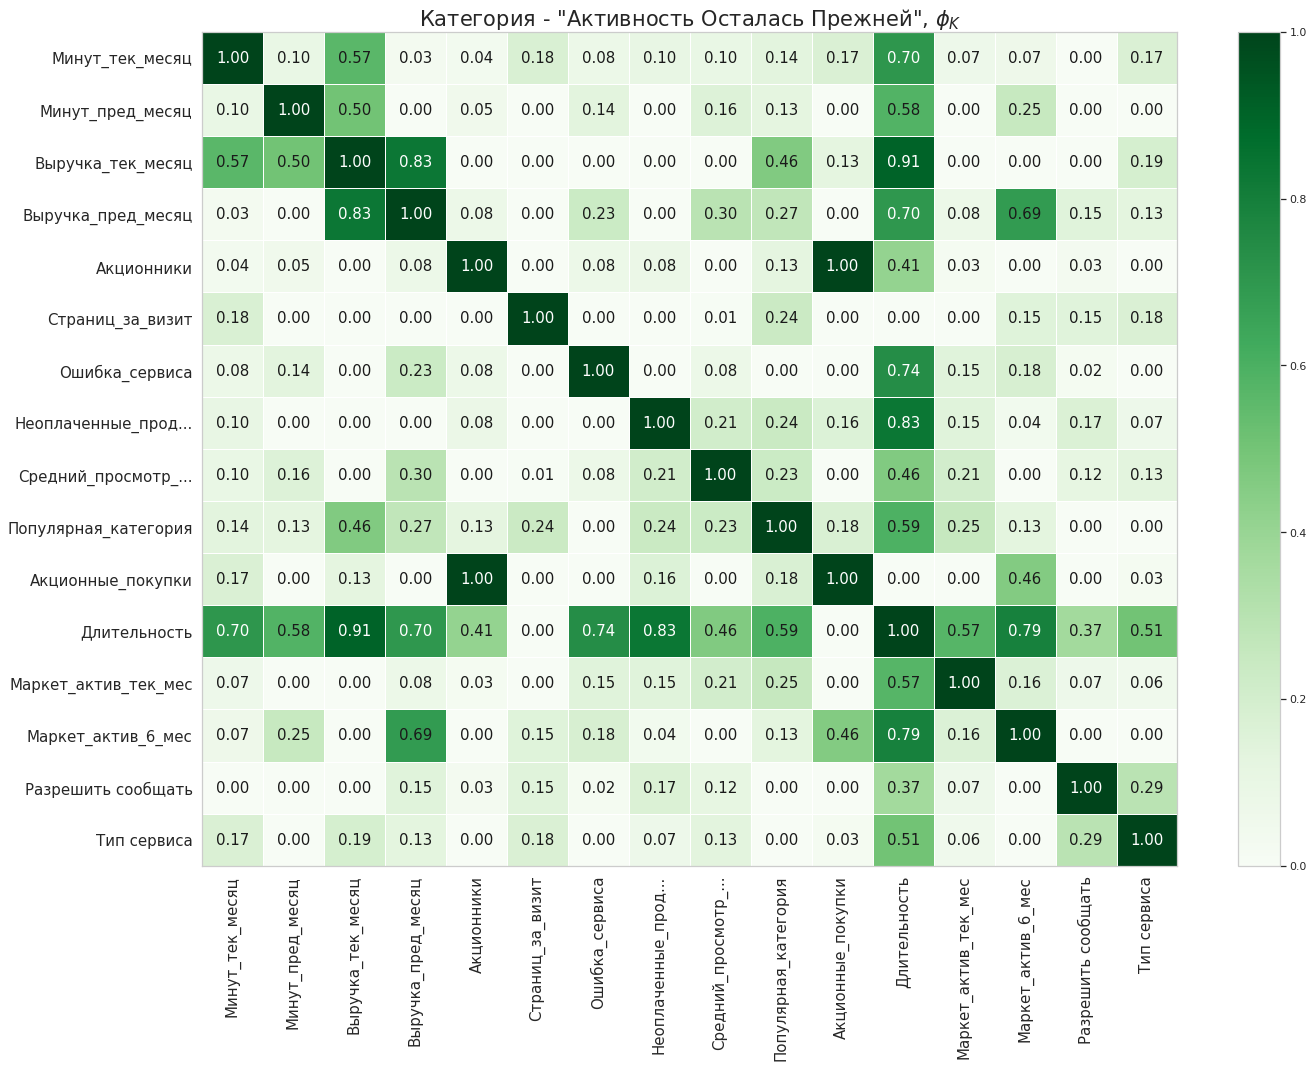

In [49]:
phik_overview_2category = phik_matrix(full[full['Покупательская активность']=='Прежний уровень'].drop(['id', 'Покупательская активность'],axis=1), interval_cols=interval_cols, bins=100)

plot_correlation_matrix(
    phik_overview_2category.values,
    x_labels=phik_overview_2category.columns,
    y_labels=phik_overview_2category.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Категория - "Активность Осталась Прежней", $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

- Вывод по корреляционному анализу:
  
- Мультиколлинеарность - это явление, при котором наблюдается сильная связь между входными признаками. Наличие мультиколлинеарности приводит к нестабильности весовых коэффициентов взаимосвязанных входных признаков, что делает модель менее точной.
  
- По нашей договоренности, мы избавимся от признаков с уровнем корреляционной связи свыше 0.75.

- В обоих случаях такая связь наблюдается только между выручкой за текущий и предыдущей месяцы. Избавимся от одного из них, например, от выручки за предыдущий месяц.
- Столбец Акционники синтетический - он закономерно коррелирует со столбцом Акционные покупки. Его тоже уберем.

In [50]:
# удаляю ненужные столбцы
full = full.drop(['Выручка_пред_месяц', 'Акционники'], axis=1)

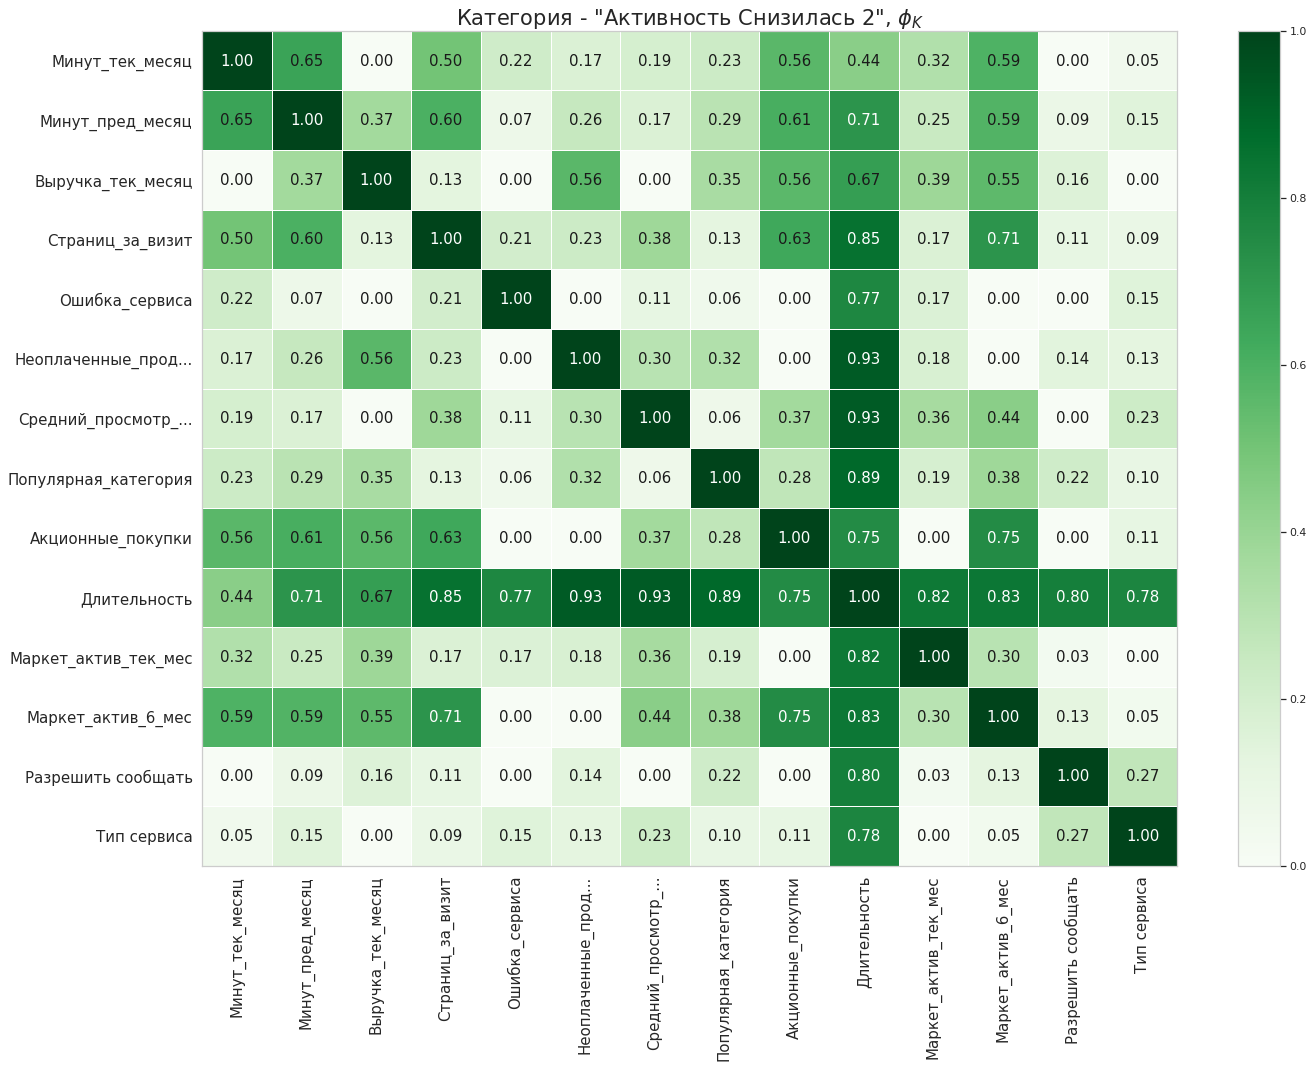

In [51]:
# проверка после удаления
phik_overview_1category = phik_matrix(full[full['Покупательская активность']=='Снизилась'].drop(['id', 'Покупательская активность'],axis=1), interval_cols=interval_cols, bins=100)

plot_correlation_matrix(
    phik_overview_1category.values,
    x_labels=phik_overview_1category.columns,
    y_labels=phik_overview_1category.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Категория - "Активность Снизилась 2", $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

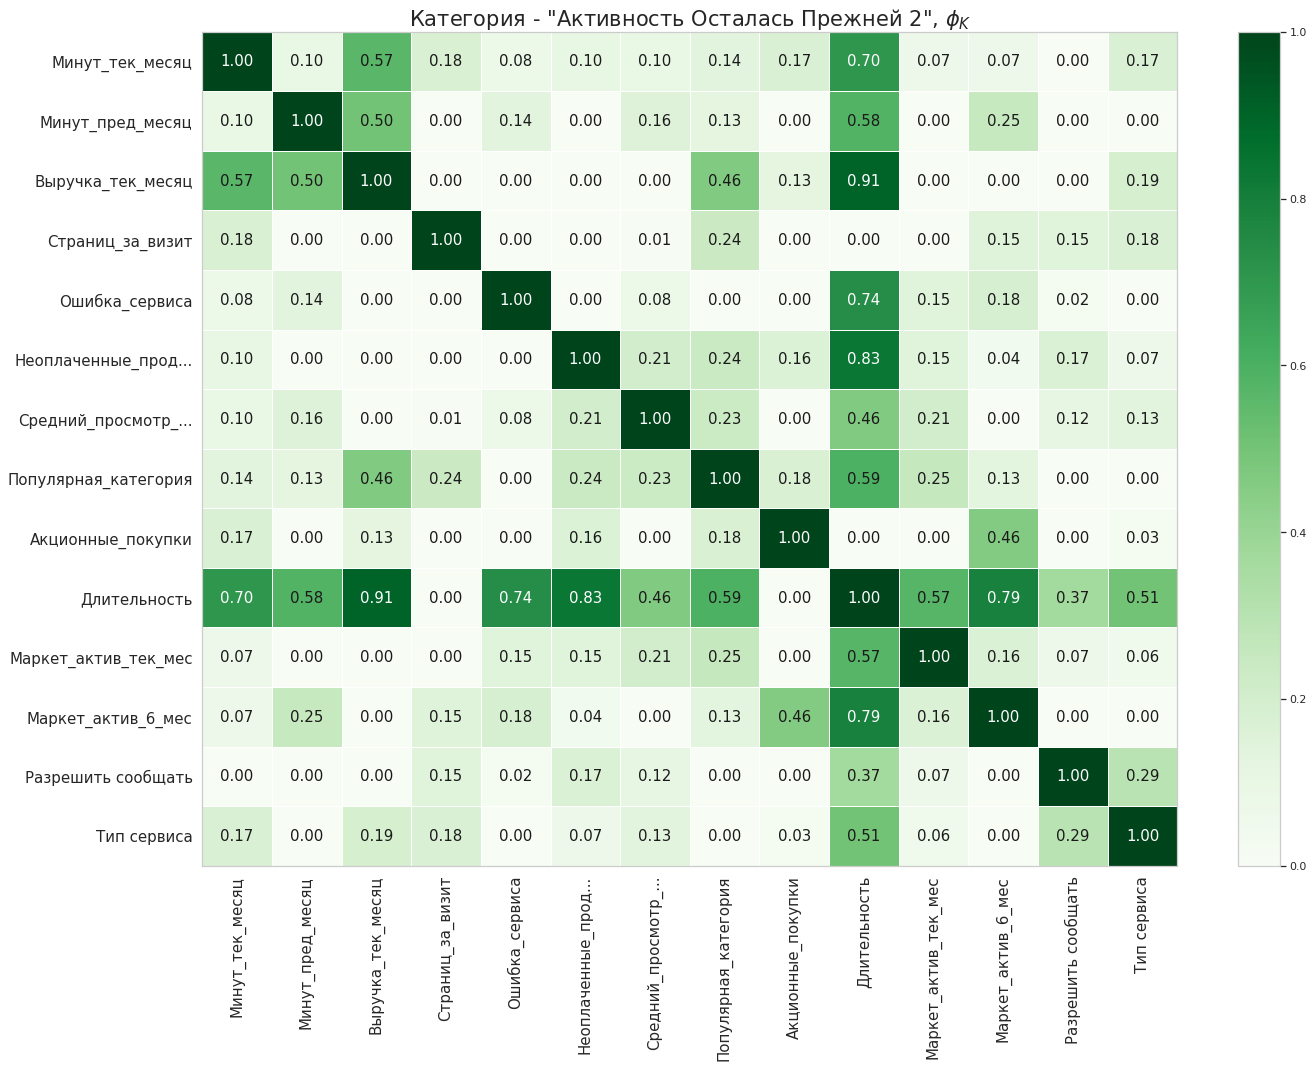

In [52]:
phik_overview_2category = phik_matrix(full[full['Покупательская активность']=='Прежний уровень'].drop(['id', 'Покупательская активность'],axis=1), interval_cols=interval_cols, bins=100)

plot_correlation_matrix(
    phik_overview_2category.values,
    x_labels=phik_overview_2category.columns,
    y_labels=phik_overview_2category.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'Категория - "Активность Осталась Прежней 2", $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
) 

### Вывод по корреляционному анализу:
  
- Мультиколлинеарность - это явление, при котором наблюдается сильная связь между входными признаками. Наличие мультиколлинеарности приводит к нестабильности весовых коэффициентов взаимосвязанных входных признаков, что делает модель менее точной.
  
- По нашей договоренности, мы избавимся от признаков с уровнем корреляционной связи свыше 0.75.

- В обоих случаях такая связь наблюдается только между выручкой за текущий и предыдущей месяцы. Избавимся от одного из них, например, от выручки за предыдущий месяц.
- Столбец Акционники синтетический - он закономерно коррелирует со столбцом Акционные покупки. Его тоже уберем.

## Шаг 6. Использование пайплайнов
Примените все изученные модели. Для этого используйте пайплайны.
- 6.1 Во время подготовки данных используйте ColumnTransformer. Количественные и категориальные признаки обработайте в пайплайне раздельно. Для кодирования категориальных признаков используйте как минимум два кодировщика, для масштабирования количественных — как минимум два скейлера.
Напоминаем, что для каждой модели можно подготовить данные с разным кодированием и масштабированием.
- 6.2 Обучите четыре модели: KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression() и  SVC(). Для каждой из них подберите как минимум один гиперпараметр. Выберите подходящую для задачи метрику, аргументируйте свой выбор. Используйте эту метрику при подборе гиперпараметров.
- 6.3 Выберите лучшую модель, используя заданную метрику. Для этого примените одну из стратегий:
использовать пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно;
использовать один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт вам лучшую модель.

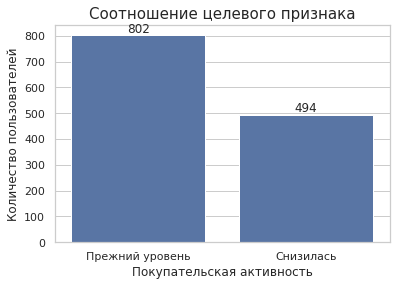

In [53]:
# баланс данных по целевому признаку:
temp = pd.DataFrame({
    'labels': full['Покупательская активность'].value_counts().index,
    'values': full['Покупательская активность'].value_counts()
})
ax = sns.barplot(data=temp, x='labels', y='values')
ax.bar_label(ax.containers[0])
plt.title('Соотношение целевого признака', fontsize=15)
plt.xlabel('Покупательская активность')
plt.ylabel('Количество пользователей')
plt.show()

In [54]:
# убираем id  и строку c nan
full = full.drop('id', axis=1).drop(index=32)
# кодируем в бинарный код целовой признак
#full['Покупательская активность'] = full['Покупательская активность'].apply(lambda x: 1 if x=='Снизилась' else 0)
full.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_тек_месяц,Минут_пред_месяц,Минут_тек_месяц
0,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,12.0,10.0
1,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,8.0,13.0
2,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,11.0,13.0
3,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,8.0,11.0
4,Снизилась,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,10.0,10.0


In [55]:
# Создаем экземпляр LabelEncoder
label_encoder = LabelEncoder()

# Кодируем столбец 'Покупательская активность'
full['Покупательская активность'] = label_encoder.fit_transform(full['Покупательская активность'])

# Выводим результат
full.head()

,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_тек_месяц,Минут_пред_месяц,Минут_тек_месяц
0,1,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,4971.6,12.0,10.0
1,1,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5058.4,8.0,13.0
2,1,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6610.4,11.0,13.0
3,1,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5872.5,8.0,11.0
4,1,стандарт,да,3.3,4,762,0.26,Домашний текстиль,4,1,1,4,5388.5,10.0,10.0


In [56]:
# делим выборки и делаем стратификацию
# т.к. присутствует дисбаланс целевого признака;
X_train, X_test, y_train, y_test = train_test_split(
    full.drop(['Покупательская активность'], axis=1),
    full['Покупательская активность'],
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = full['Покупательская активность']
)


# проверим размерность
print('Размерность выборки X_train: ', X_train.shape)
print('Размерность выборки X_test: ', X_test.shape)
print('Размерность выборки y_train: ', y_train.shape)
print('Размерность выборки y_test: ', y_test.shape)

Размерность выборки X_train:  (971, 14)
Размерность выборки X_test:  (324, 14)
Размерность выборки y_train:  (971,)
Размерность выборки y_test:  (324,)


In [57]:
# разделим признаки ohe_col - категориальный признак,
#Для этого признака будет применяться One-Hot Encoding (OHE), чтобы преобразовать его в бинарные столбцы.
ohe_col = ['Разрешить сообщать', 'Популярная_категория']

# ord_col - порядковый признак
ord_col = ['Тип сервиса']

# числовой 
num_col = list(
    full.drop(
        ['Тип сервиса', 'Разрешить сообщать', 'Популярная_категория', 'Покупательская активность'],
        axis=1)
    .columns
)

In [58]:
# Собираю пайплайн для обработки категориальных данных с использованием One-Hot Encoding
ohe_pipe = Pipeline(
    [
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

# Собираю пайплайн для обработки порядковых данных с использованием Ordinal Encoding
ord_pipe = Pipeline(
    [
     ('ord',  OrdinalEncoder(
                categories=[
                    ['премиум', 
                     'стандарт'
                    ], 
                    
                ]
            )
        ),
    ]
)
# Создаю ColumnTransformer для объединения различных пайплайнов обработки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_col),
     ('ord', ord_pipe, ord_col),
     ('num', MinMaxScaler(), num_col)
    ], 
    remainder='passthrough'
)
# Создаю финальный пайплайн, который включает предварительную обработку данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

## Метрики:
- F1-мера (F1 Score): Измеряет точность и полноту модели. Эта метрика помогает оценить способность модели правильно классифицировать положительные и отрицательные примеры. F1-мера является хорошим выбором, когда у нас есть дисбаланс классов.
- ROC-AUC (Receiver Operating Characteristic - Area Under the Curve): Оценивает способность модели различать между классами. Он измеряет площадь под ROC-кривой, которая показывает отношение между долей верно классифицированных положительных и долей ложноположительных результатов при изменении порогового значения.


In [59]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(2, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
     # словарь для модели SVC
     {
        'models': [SVC(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  

    }
]



randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring=['roc_auc', 'f1'],  # Оценка по двум метрикам
    refit='roc_auc',             # Оптимизация по ROC AUC
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)


print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print('Гиперпараметры', randomized_search.best_params_)

print ('Метрика лучшей модели на кросс-валидации.:', randomized_search.best_score_)

# Предсказания вероятностей на тестовой выборке
y_pred_proba = randomized_search.predict_proba(X_test)[:, 1]  # Предполагаем, что класс 1 — положительный

# Вычисляем ROC AUC на тестовой выборке
roc_auc = roc_auc_score(y_test, y_pred_proba)
print('Метрика ROC AUC на тестовой выборке:', roc_auc)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Разрешить сообщать',
                                                   'Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(categories=[['премиум',
                                                  

## Вывод по работе модели:
Лучшкей моделью оказалась модель LogisticRegression (логистическая регрессия) с гиперпараметрами:
- C=3
- penalty=l1
  
Результат по метрикам немного удивил - лучшая метрика на тренировочной выборке примерно равна 0.90 - это хороший результат, но метрика на тестовой выборке еще выше! Она равна приблизительно 0.91 - это очень высокий результат особенно для тестовой выборки. 

## Шаг 7. Анализ важности признаков
- 7.1 Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP. 
- 7.2 Сделайте выводы о значимости признаков:
какие признаки мало значимы для модели;
какие признаки сильнее всего влияют на целевой признак;
как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.

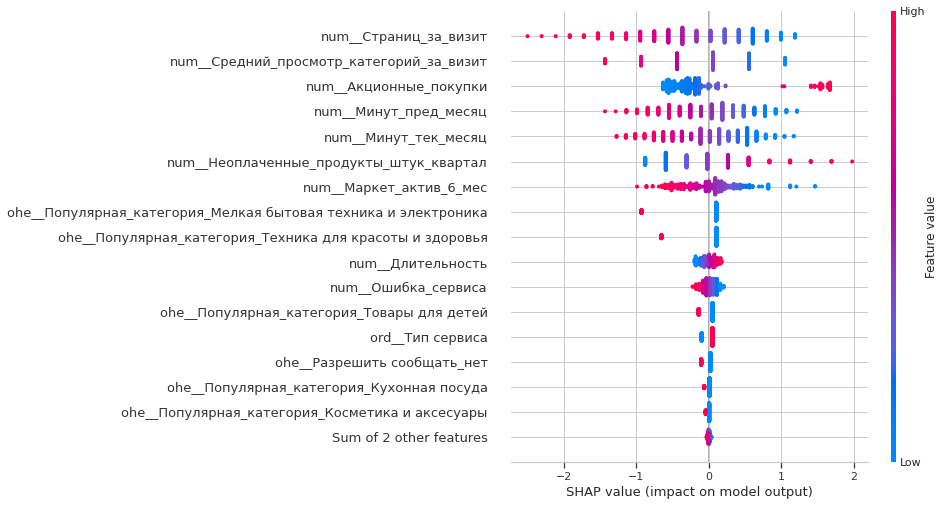

In [60]:
# Преобразуем тестовые данные с использованием лучшего найденного пайплайна
X_test_new = randomized_search.best_estimator_['preprocessor'].fit_transform(X_test)

# Создаем DataFrame из преобразованных данных с новыми именами признаков
X_test_new = pd.DataFrame(X_test_new, columns=randomized_search.best_estimator_['preprocessor'].get_feature_names_out())

# Инициализируем объяснитель SHAP для линейной модели, используя обученную модель и преобразованные тестовые данные
explainer = shap.LinearExplainer(randomized_search.best_estimator_['models'], X_test_new)

# Вычисляем значения SHAP для тестовых данных
shap_values = explainer(X_test_new)

# Визуализируем значения SHAP с помощью графика "пчелиный рой", отображая до 17 наиболее значимых признаков
shap.plots.beeswarm(shap_values, max_display=17)


## Вывод по анализу важности признаков
- Сильнее всего на результат модели влияет признак `Страниц_за_визит`, по графику видно чем больше страниц за визит смотрит отдельный пользователь тем больше шанс, что его пользовательская активность останется на прежнем уровне. Это выглядит вполне логично, ведь чем дольше пользователь выбирает как-либо товар, тем больше шанс, что он его приобретет.
- Со `cредним просмотром за визит` примерно такая ситуация и ее объяснение практически аналогично первому
- С `минутами` все тоже понятно, чем больше пользователь проводит времени на сайте тем больше вероятность того, что его пользовательская активность останется на прежнем уровне.
- С `акционными покупками` ситуация интереснее, но если задуматься она выглядит очень правдоподобно. Чем больше пользователь покупает по акциям - тем меньше шанс, что это просто не тот человек который отлавливает акции и скидки. Для большего понимания стоит привети пример: когда в интернет магазине проходит какая-либо акция или появляется кака-либо хорошая скидка на продукт, множество людей покупают его на этом сайте, потому что это выгодно, но они как не были пользователями этого магазина, так и в большинстве своем (конечно не все) ими не станут.
- С `неоплачеными продуктами` тоже все просто. Чем больше у пользователя неоплаченых покупок, тем больше шанс того, что его покупательская активность снизится - это звучит логично.
- C `маркетинговой активностью` все тоже понятно, чем больше ее было в течении полугода, тем больше шанс, что пользователь продолжит пользоваться продуктом.
- `Популярная категория` тоже имеет свой вес, например если человек покупал какую либо технику в этом магазине - тем больше шанс, что его пользовательская активность останется на прежнем уровне, а вот пользователи которые покупают домашний текстиль или косметику с аксесуарами с большей вероятностью будут уходить с этого магазина.


## Шаг 8. Сегментация покупателей
- 8.1 Выполните сегментацию покупателей. Используйте результаты моделирования и данные о прибыльности покупателей.
- 8.2 Выберите группу покупателей и предложите, как увеличить её покупательскую активность: 
Проведите графическое и аналитическое исследование группы покупателей.
Сделайте предложения по работе с сегментом для увеличения покупательской активности.
- 8.3 Сделайте выводы о сегментах:
какой сегмент вы взяли для дополнительного исследования,
какие предложения вы сделали и почему.

- Первая группа: покупатели с высокой долей акционных покупок и снижающейся активностью. Это, вероятно, "ловцы акций", которые ищут товары по скидке. Рекомендуется анализировать их любимые категории и предлагать скидки на них, чтобы повысить их интерес к магазину.

In [61]:
def histogram_creator(df: pd.DataFrame,
                      parametr:str,
                      bins: int,
                      title: str,
                      xlabel: str,
                      ylabel: str,
                      hue=None
                     ) -> None:
   
    '''
    Функция принимает в качестве параметров датафрейм, параметр (название столбца)
    по которому будет строится гистограмма, число бинов и строки с названием всего графика,
    оси Ox и оси Oy, соответственно.
   
    На выходе функция не возвращает ничего. Функция строит гистограмму по заданному параметру.
    ''' 

    sns.set()
    plt.figure(figsize=(15, 8))
    sns.histplot(data=df,
                 x=parametr,
                 bins=bins,
                 color='#4f4d49',
                 edgecolor='black',
                 kde=True
    )
    plt.title(title,
              fontsize=20,
              fontweight='bold'
             )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    display(df[parametr].describe())

In [62]:
# Получаем лучший найденный пайплайн из RandomizedSearchCV
model = randomized_search.best_estimator_

# Предсказываем вероятности для тестовых данных. 
# Мы берем только вероятности для положительного класса (второй столбец).
result = pd.DataFrame(model.predict_proba(X_test)[:, 1], columns=['вероятность_снижения'], index=X_test.index)

# Объединяем предсказанные вероятности с исходными тестовыми данными по индексу
proba_df = X_test.merge(result, left_index=True, right_index=True)

# Объединяем полученные данные с дополнительной информацией о деньгах (например, выручка или траты)
proba_df = proba_df.merge(income, left_index=True, right_index=True)

# Выводим первые 5 строк результирующего DataFrame для проверки
proba_df.head()

,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,Выручка_тек_месяц,Минут_пред_месяц,Минут_тек_месяц,вероятность_снижения,id,Прибыль
1094,стандарт,да,5.3,5,433,0.91,Техника для красоты и здоровья,1,1,0,7,5230.7,15.0,20.0,0.472771,216442,5.10
303,стандарт,да,3.9,4,819,0.94,Товары для детей,1,9,4,2,4909.3,13.0,10.0,0.997420,215651,5.15
949,премиум,да,3.9,5,410,0.20,Косметика и аксесуары,3,1,5,14,4926.4,17.0,13.0,0.058128,216297,5.25
150,стандарт,да,3.1,4,342,0.98,Кухонная посуда,2,7,5,3,6314.0,13.0,10.0,0.993352,215498,3.14
582,стандарт,нет,5.5,4,147,0.99,Мелкая бытовая техника и электроника,1,2,3,7,5773.8,15.0,18.0,0.476411,215930,2.77


## Покупатели с высокой долей акционных покупок


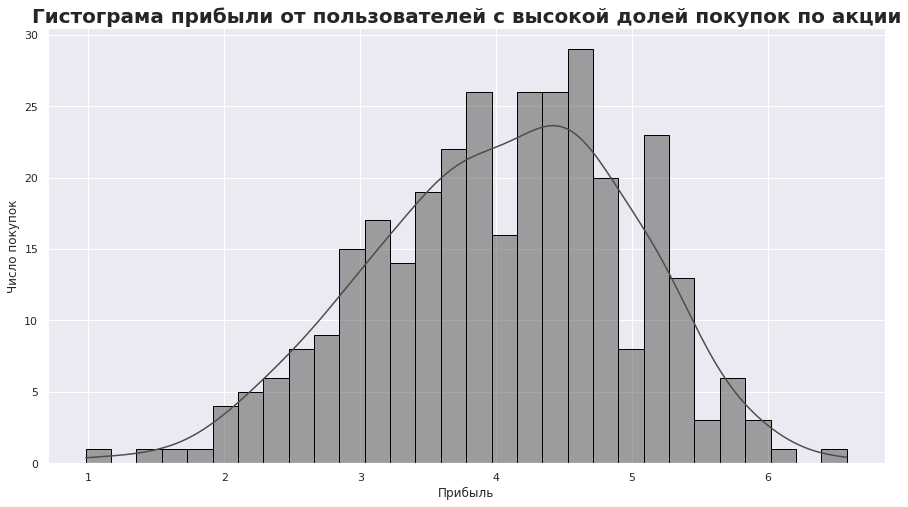

count    324.000000
mean       4.035772
std        0.945995
min        0.980000
25%        3.397500
50%        4.115000
75%        4.682500
max        6.580000
Name: Прибыль, dtype: float64

In [63]:
histogram_creator(proba_df,
                  'Прибыль',
                  30,
                  'Гистограма прибыли от пользователей с высокой долей покупок по акции',
                  'Прибыль',
                  'Число покупок'
                 )

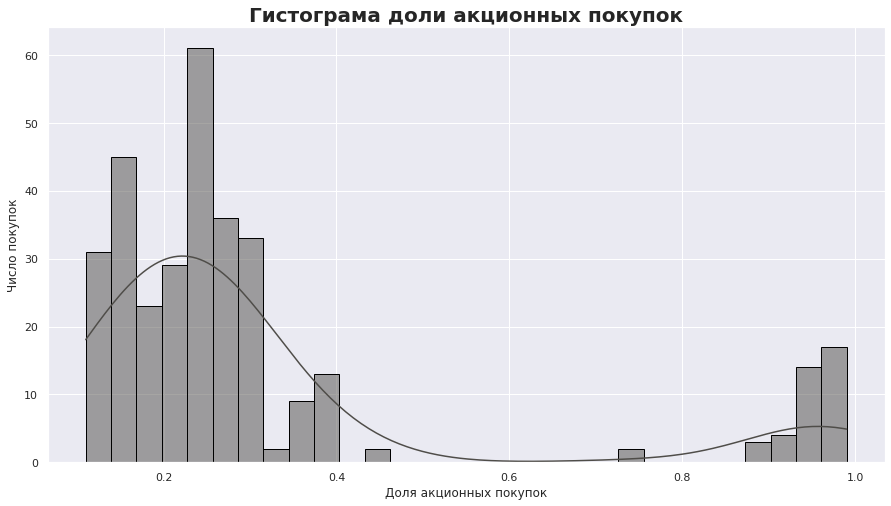

count    324.000000
mean       0.316759
std        0.247142
min        0.110000
25%        0.170000
50%        0.240000
75%        0.300000
max        0.990000
Name: Акционные_покупки, dtype: float64

In [64]:
histogram_creator(proba_df,
                  'Акционные_покупки',
                  30,
                  'Гистограма доли акционных покупок',
                  'Доля акционных покупок',
                  'Число покупок'
                 )

Как раньше и было в анализе - есть два сегмента - те, кто покупают по акции очень чатсо и не очень.

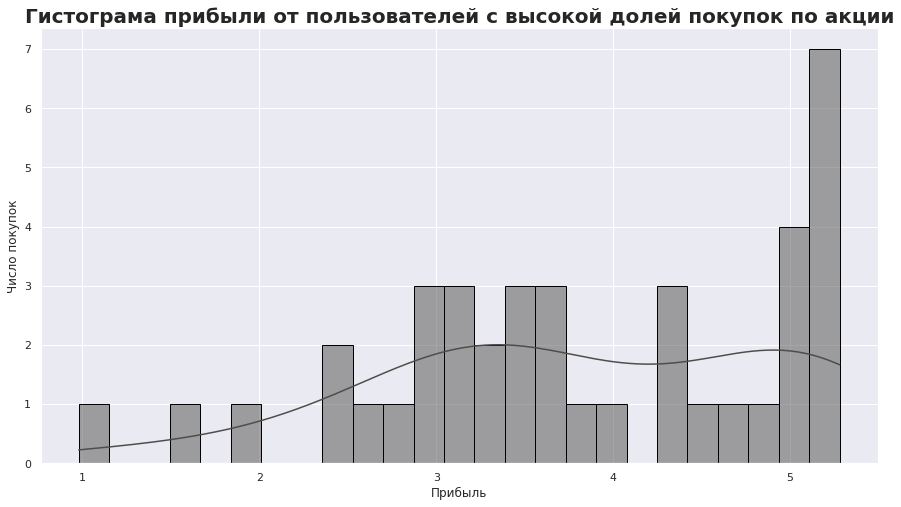

count    40.000000
mean      3.818750
std       1.138438
min       0.980000
25%       3.092500
50%       3.690000
75%       5.082500
max       5.280000
Name: Прибыль, dtype: float64

In [65]:
histogram_creator(proba_df.query('Акционные_покупки >= 0.6'),
                  'Прибыль',
                  25,
                  'Гистограма прибыли от пользователей с высокой долей покупок по акции',
                  'Прибыль',
                  'Число покупок'
                 )

In [66]:
def scatterplot_creator(df: pd.DataFrame,
                        parametr_x: str,
                        parametr_y: str,
                        title: str,
                        xlabel: str,
                        ylabel: str,
                        hue=None, 
                       ) -> None:
    
    '''
    Функция принимает на фход датафрейм, параметры по которым будет строиться график и 
    именя для оглавления всего графиков и имен осей. По заданным параметрам функция 
    нарисует диаграмму рассеяния и отобразит коэффициент корреляции.
    
    Функция ничего не возвращает.
    '''
    
    sns.set()
    plt.figure(figsize=(9,9)),
    sns.scatterplot(
        data=df,
        x=parametr_x,
        y=parametr_y,
        hue=hue
    )
    plt.title(title,
              fontsize=20,
              fontweight='bold'
             )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    display(df[[parametr_y, parametr_x]].corr())

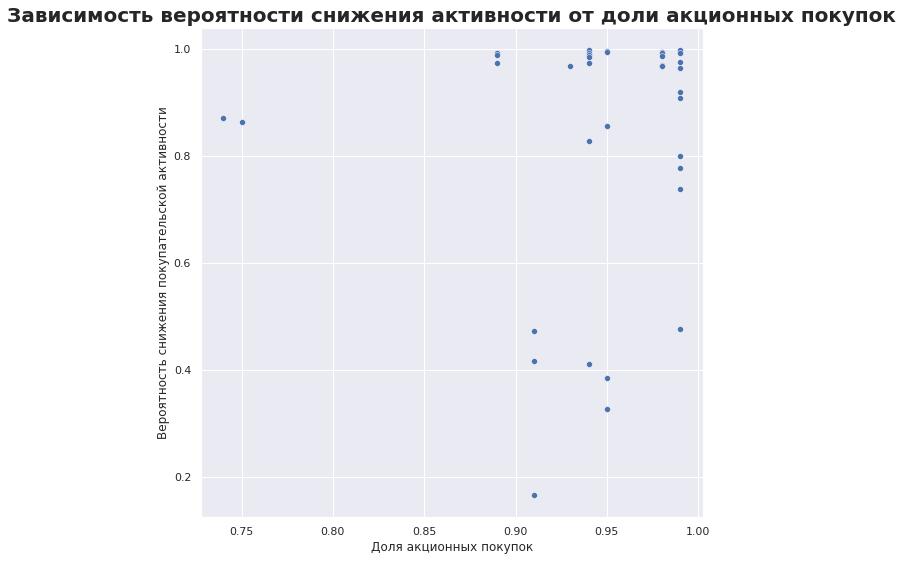

,вероятность_снижения,Акционные_покупки
вероятность_снижения,1.000000,0.102098
Акционные_покупки,0.102098,1.000000


In [67]:
scatterplot_creator(proba_df.query('Акционные_покупки >= 0.6'),
                    'Акционные_покупки',
                    'вероятность_снижения',
                    'Зависимость вероятности снижения активности от доли акционных покупок',
                    'Доля акционных покупок',
                    'Вероятность снижения покупательской активности' 
                    )

Судя по этому графику, пользователи с высокой долей покупок по акциям реже остаются клиентами магазина. Это позволяет сделать вывод, что, скорее всего, это "охотники за акциями". Стратегии с такой категорией:
- предлагать им акции в их любимых категориях.
- Разработать программу лояльности, которая будет вознаграждать клиентов за повторные покупки. Это может включать накопительные скидки или специальные предложения для постоянных клиентов.
  
Чтобы разработать стратегии привлечения и удержания этих клиентов, необходимо выяснить, есть ли у "охотников за акциями" предпочтительные категории товаров. В этом варианте текст стал более структурированным и читабельным. 

In [68]:
def pie_creator(df: pd.DataFrame, parametr: str, title: str) -> None:
   
    '''
    Функция принимает на вход изучаемый датафрейм, параметр по которому будет проводиться
    рассчет и назавние которое будет у графика.
    
    Функция не возвращает ничего, а чертит график.
    '''
    
    sns.set()
    plt.figure(figsize=(7, 7))
    plt.pie(
        x=df[parametr].value_counts(),
        autopct='%1.1f%%',
        labels=df[parametr].value_counts().index,
    )
    plt.title(title,
              fontsize=14,
              fontweight='bold'
             )
    plt.show()

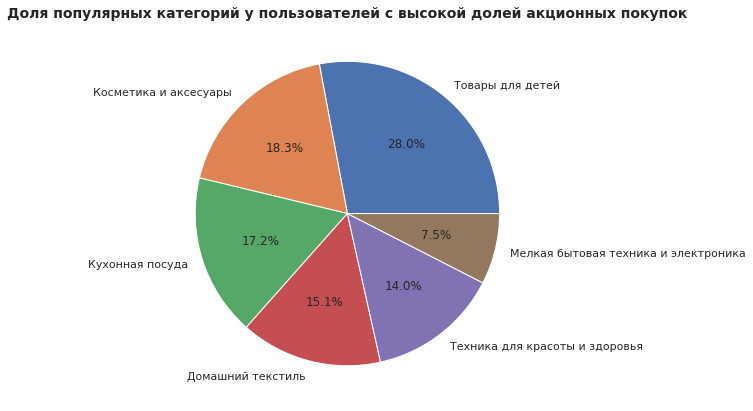

In [69]:
pie_creator(proba_df.query('Акционные_покупки >= 0.3'),
            'Популярная_категория',
            'Доля популярных категорий у пользователей с высокой долей акционных покупок')

Топ 3 категории - Товары для детей, Кухонная посуда и Косметика и Аксессуары. В этих категориях нужны новые акции + добавлять в эти акции другие категории, чтобы акционники видели и другой товар.
Следующий сегмент я бы взяла - что именно покупают акционники и делала бы модель для прогнозирования их предложений.
Вторая стратегия - программа лояльности с накоплением баллов.

## Шаг 9. Общий вывод
## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.


Что нужно сделать:

- Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
- В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
- Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.
  
## Вывод про исходные данные и проведённую предобработку:


- неправильные типы данных `Маркет_актив_6_мес`, `Акционные_покупки`, `Выручка`
- пропусков нет
- данные соответствуют описанию
- названия столбцов оставлю как есть.

- испавлены опечатки  в`main['Тип сервиса']` (стандарт) и  в `time['Период']` (предыдущий_месяц)
- дубликаты не выявлены
- смена типов данных в `main['Маркет_актив_6_мес']`, `money['Выручка']`,
`main['Акционные_покупки']` на float.

## Вывод про иследовательский анализ:

Датафрейм main:

- `Маркет_актив_6_мес `— среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев равно примерно 4 коммуникациям. В целом проходит от 1 до 6.
- `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце так же в среднем около 4 штук. В целом проходит от 3 до 5.
-` Длительность `— 600 дней - среднее кол-во дней прошло с момента регистрации покупателя на сайте. 
Большинство клиентов достаточно давно зарегистрировались. Размах от 110 дней до 1079.
- `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев - низкая.
Средняя и медиана разные, видна ассиметрия - два пика. Скорее всего есть две категории - кто кладет мин акционных товаров и кто покупает только их.
Похоже на первую сегментацию.
- Сегмент `Только по акции`- покупают больше всего товары для детей.
- `Средний_просмотр_категорий_за_визит` — 3-4 категории в среднем покупатель просмотрел за визит в течение последнего месяца.
- `Неоплаченные_продукты_штук_квартал` — около 3 неоплаченных товаров в корзине за последние 3 месяца.
- `Ошибка_сервиса` — 4 - число сбоев, которые коснулись покупателя во время посещения сайта.
- `Страниц_за_визит` — около 8 - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.
- `Покупательская активность` — больше осталась на прежнем уровне.
- `Тип сервиса` — стандарт больше, чем премиум.
- `Разрешить сообщать` — большинство отвечают - да.
- `Популярная_категория` — топ3: товары для детей, дом текстиль, косметика и аксессуары.

Датафреймы Money и Income

- `Период` — выручки по предыдущему месяцу было больше.
- `Выручка` — за все периоды за одного клиента около в среднем 5000. Максимальная выручка - 7799 и это в текущем месяце. В предыдущем выручка просела.
- `Прибыль` — среднее значение среднемесячной прибыли покупателя за последние 3 месяца - около 4.
  
Датафрейм time

- Около 12.5 минут в среднем проводит клиент.
- В текущем месяце клиент проводит гораздо больше времени на сайте.

## Вывод по корреляционному анализу:
  
- Мультиколлинеарность - это явление, при котором наблюдается сильная связь между входными признаками. Наличие мультиколлинеарности приводит к нестабильности весовых коэффициентов взаимосвязанных входных признаков, что делает модель менее точной.
  
- По нашей договоренности, мы избавимся от признаков с уровнем корреляционной связи свыше 0.75.

- В обоих случаях такая связь наблюдается только между выручкой за текущий и предыдущей месяцы. Избавимся от одного из них, например, от выручки за предыдущий месяц.
- Столбец Акционники синтетический - он закономерно коррелирует со столбцом Акционные покупки. Его тоже уберем.

## Вывод по работе модели:
Лучшкей моделью оказалась модель LogisticRegression (логистическая регрессия) с гиперпараметрами:
- C=3
- penalty=l1
  
Результат по метрикам немного удивил - лучшая метрика на тренировочной выборке примерно равна 0.90 - это хороший результат, но метрика на тестовой выборке еще выше! Она равна приблизительно 0.91 - это очень высокий результат особенно для тестовой выборки. 

## Вывод по анализу важности признаков
- Сильнее всего на результат модели влияет признак `Страниц_за_визит`, по графику видно чем больше страниц за визит смотрит отдельный пользователь тем больше шанс, что его пользовательская активность останется на прежнем уровне. Это выглядит вполне логично, ведь чем дольше пользователь выбирает как-либо товар, тем больше шанс, что он его приобретет.
- Со `cредним просмотром за визит` примерно такая ситуация и ее объяснение практически аналогично первому
- С `минутами` все тоже понятно, чем больше пользователь проводит времени на сайте тем больше вероятность того, что его пользовательская активность останется на прежнем уровне.
- С `акционными покупками` ситуация интереснее, но если задуматься она выглядит очень правдоподобно. Чем больше пользователь покупает по акциям - тем меньше шанс, что это просто не тот человек который отлавливает акции и скидки. Для большего понимания стоит привети пример: когда в интернет магазине проходит какая-либо акция или появляется кака-либо хорошая скидка на продукт, множество людей покупают его на этом сайте, потому что это выгодно, но они как не были пользователями этого магазина, так и в большинстве своем (конечно не все) ими не станут.
- С `неоплачеными продуктами` тоже все просто. Чем больше у пользователя неоплаченых покупок, тем больше шанс того, что его покупательская активность снизится - это звучит логично.
- C `маркетинговой активностью` все тоже понятно, чем больше ее было в течении полугода, тем больше шанс, что пользователь продолжит пользоваться продуктом.
- `Популярная категория` тоже имеет свой вес, например если человек покупал какую либо технику в этом магазине - тем больше шанс, что его пользовательская активность останется на прежнем уровне, а вот пользователи которые покупают домашний текстиль или косметику с аксесуарами с большей вероятностью будут уходить с этого магазина.


## Вывод по сегментации:

Судя по этому графику, пользователи с высокой долей покупок по акциям реже остаются клиентами магазина. Это позволяет сделать вывод, что, скорее всего, это "охотники за акциями". Стратегии с такой категорией:

- предлагать им акции в их любимых категориях.
- разработать программу лояльности, которая будет вознаграждать клиентов за повторные покупки. Это может включать накопительные скидки или специальные предложения для постоянных клиентов.
  
Чтобы разработать стратегии привлечения и удержания этих клиентов, необходимо выяснить, есть ли у "охотников за акциями" предпочтительные категории товаров. В этом варианте текст стал более структурированным и читабельным.

Топ 3 категории - Товаря для детей, Кухонная посуда и Косметика и Аксессуары. В этих категориях нужны новые акции + добавлять в эти акции другие категории, чтобы акционники видели и другой товар.
Следующий сегмент я бы взяла - что именно покупают акционники и делала бы модель для прогнозирования их предложений.
Вторая стратегия - программа лояльности с накоплением баллов.